_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Sascha Mühlinghaus, Max Bardelang

LLM Disclaimer: Copilot for generating repetitive code in plotting , boilerplate code and nasty indexing tasks

# Coding Lab 7 : Transcriptomics

In [55]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-07 11:32:59CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

sklearn: 1.6.1

igraph    : 0.11.8
matplotlib: 3.10.1
leidenalg : 0.10.2
numpy     : 2.2.5
openTSNE  : 1.0.2
sklearn   : 1.6.1
pandas    : 2.2.3

Watermark: 2.5.0



In [56]:
plt.style.use("../matplotlib_style.txt")

# Introduction

In this notebook you are going to work with transcriptomics data, in particular single-cell RNA sequencing (scRNA-seq) data from the paper by [Harris et al. (2018)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387). They recorded the transcriptomes of 3,663 inhibitory cells in the hippocampal area CA1. Their analysis divided these cells into 49 fine-scale clusters coresponding to different cell subtypes. They asigned names to these cluster in a hierarchical fashion according to strongly expressed gene in each clusters. The figure below shows the details of their classification. 

You will first analyze some of the most relevant statistics of UMI gene counts distributions, and afterwards follow the standard pipeline in the field to produce a visualization of the data.

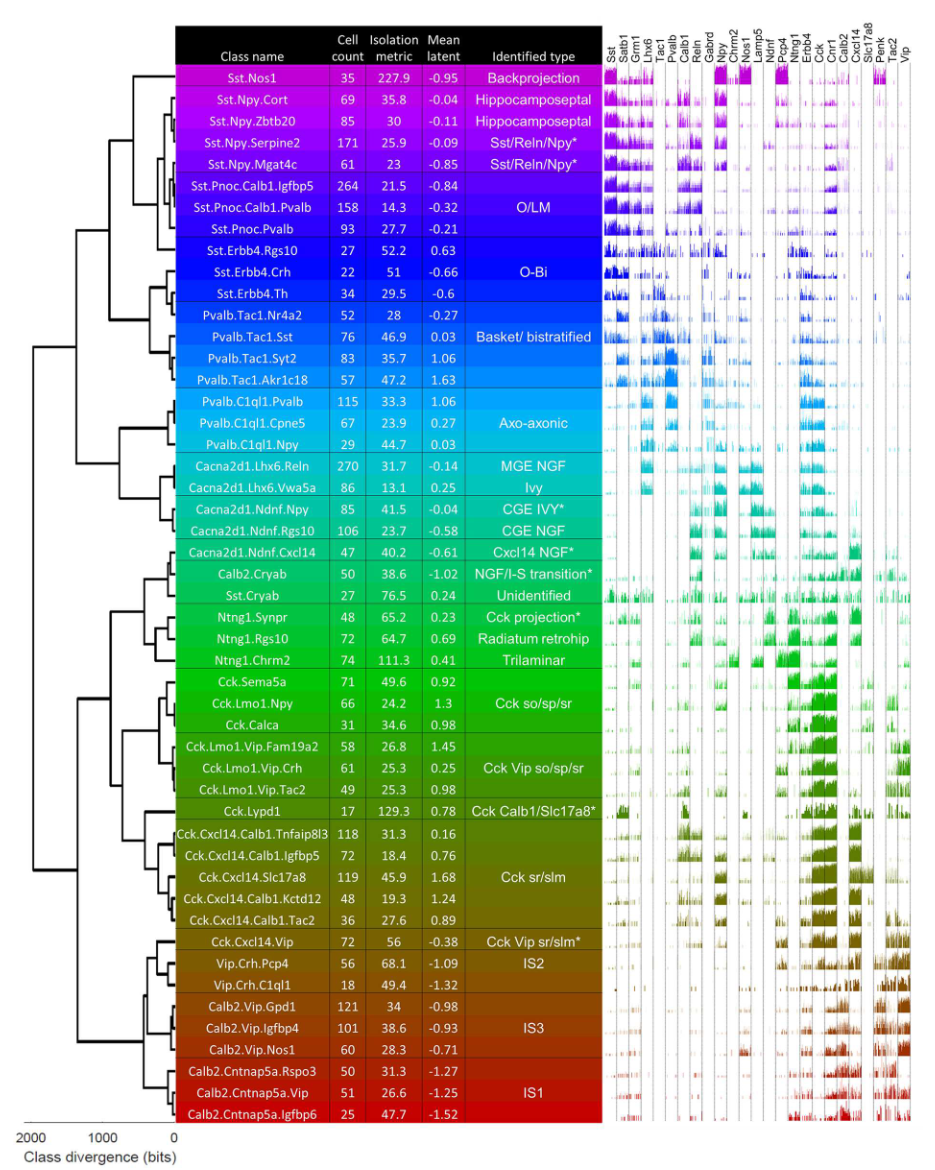

## Load data

Download the data from ILIAS, move it to the `data/` directory and unzip it there.
The read counts can be found in `counts`, with rows corresponding to cells and columns to genes.
The cluster assignments for every individual cell can be found in  `clusters`, along with the colors used in the publication in  `clusterColors`.

In [57]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


# Task 1: Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
Compute actual and predicted gene expression. The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. Plot the data and explain what you see in the plot.


_(3 pts)_

In [58]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1 pt)
# ------------------------------------------------------


# Compute the average expression for each gene
# Compute the fraction of zeros for each gene
def compute_gene_expression(counts, genes):
    avg_expression = np.mean(counts, axis=0)
    fraction_zeros = np.sum(counts == 0, axis=0) / counts.shape[0]
    return pd.DataFrame(
        {
            "gene": genes,
            "avg_expression": avg_expression,
            "fraction_zeros": fraction_zeros,
        }
    )


# call the function on the counts and genes
gene_expression = compute_gene_expression(counts, genes)
gene_expression.shape

(17965, 3)

In [59]:
# Compute the Poisson prediction
# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
def poisson_fraction_zeros(mean):
    return np.exp(-mean)


# apply the function to the average expression
gene_expression["poisson_fraction_zeros"] = gene_expression["avg_expression"].apply(
    poisson_fraction_zeros
)
# compute the difference between the actual and predicted fraction of zeros
gene_expression["fraction_zeros_diff"] = (
    gene_expression["fraction_zeros"] - gene_expression["poisson_fraction_zeros"]
)
# sort the genes by the difference
gene_expression = gene_expression.sort_values("fraction_zeros_diff", ascending=False)
print(gene_expression.head())

         gene  avg_expression  fraction_zeros  poisson_fraction_zeros  \
8683      Vip        3.885886        0.769315                0.020530   
15139   Pvalb        2.892711        0.771226                0.055426   
16021    Pcp4        2.342888        0.800983                0.096050   
13874  Cxcl14        5.031668        0.702703                0.006528   
9860   Yjefn3        2.654928        0.719629                0.070304   

       fraction_zeros_diff  
8683              0.748785  
15139             0.715800  
16021             0.704933  
13874             0.696175  
9860              0.649325  


In [60]:
gene_expression.shape

(17965, 5)

In [61]:
gene_expression["gene"].unique()

array(['Vip', 'Pvalb', 'Pcp4', ..., 'Med6', 'Gm6563', 'Gpatch1'],
      shape=(17954,), dtype=object)

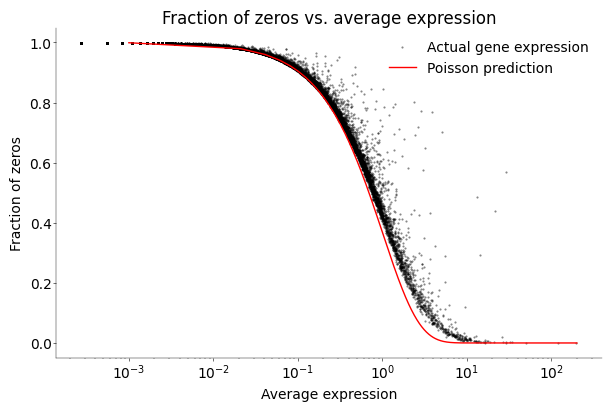

In [62]:
# --------------------------------------------------
# plot the data and the Poisson prediction (1 pt)
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(
    gene_expression["avg_expression"],
    gene_expression["fraction_zeros"],
    s=1,
    color="black",
    alpha=0.5,
    label="Actual gene expression",
)
# add the Poisson prediction
x = np.linspace(0.001, 200, 10000)
ax.plot(
    x,
    poisson_fraction_zeros(x),
    color="red",
    label="Poisson prediction",
)
ax.set_xscale("log")
ax.set_xlabel("Average expression")
ax.set_ylabel("Fraction of zeros")
ax.set_title("Fraction of zeros vs. average expression")
ax.legend()

_Explanation (1 pt)_

The probability of observing a zero count in a Poisson distribution is given by:

$$P(X=0) = \frac{\lambda^0 e^{-\lambda}}{0!} = e^{-\lambda}$$

We illustrate this relationship by plotting the fraction of zero counts for each gene against the mean expression of that gene on a log-scale. We see that the Poisson prediction matches the actual gene expression fraction quite closely, yet not perfectly. This indicates that the data is not exactly Poisson distributed, but rather follows a similar distribution with some deviations, e.g, a negative binomial distribution.

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance. Plot the mean-variance relationship and interpret the plot.

_(2.5 pts)_

In [63]:
# -------------------------------------------------------------------
# Compute the variance of the expression counts of each gene (0.5 pt)
# -------------------------------------------------------------------
gene_var = np.var(counts, axis=0)
# Add the variance to the gene expression DataFrame
gene_expression["variance"] = gene_var

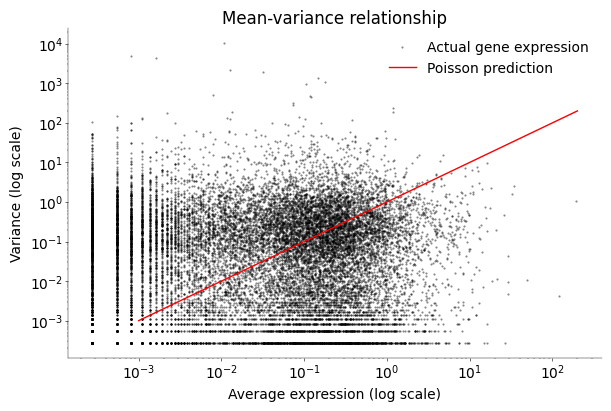

In [64]:
# -------------------------------------------------------------
# Plot the mean-variance relationship on a log-log plot (1 pt)
# Plot the Poisson prediction as a line
# -------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(
    gene_expression["avg_expression"],
    gene_expression["variance"],
    s=1,
    color="black",
    alpha=0.5,
    label="Actual gene expression",
)
# add the Poisson prediction
x = np.linspace(0.001, 200, 1000)
ax.plot(
    x,
    x,  # Poisson prediction is a line with slope 1
    color="red",
    label="Poisson prediction",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Average expression (log scale)")
ax.set_ylabel("Variance (log scale)")
ax.set_title("Mean-variance relationship")
ax.legend()

_Explanation (1 pt)_
...

### 1.3. Relationship between the mean and the Fano factor

Compute the Fano factor for each gene and make a scatter plot of expression mean vs. Fano factor in log-log coordinates, and interpret what you see in the plot. If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(2.5 pts)_

In [65]:
# --------------------------------------------
# Compute the Fano factor for each gene (0.5 pt)
# --------------------------------------------
fano = gene_expression["variance"] / gene_expression["avg_expression"]
fano.shape

(17965,)

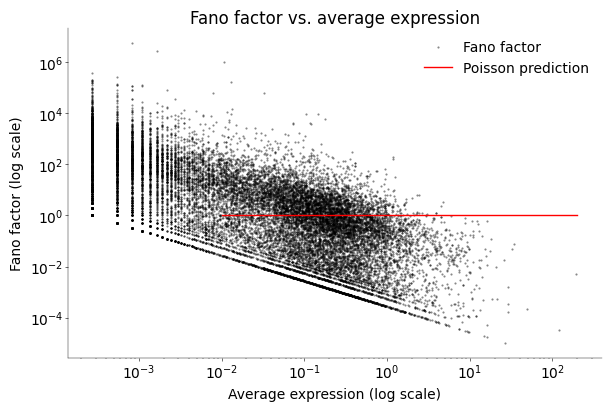

In [66]:
# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    gene_expression["avg_expression"],
    fano,
    s=1,
    color="black",
    alpha=0.5,
    label="Fano factor",
)

# add the Poisson prediction
x = np.linspace(0.01, 200, 1000)
ax.plot(
    x,
    np.ones_like(x),  # Poisson prediction is a line with slope 1
    color="red",
    label="Poisson prediction",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Average expression (log scale)")
ax.set_ylabel("Fano factor (log scale)")
ax.set_title("Fano factor vs. average expression")
ax.legend()

_Explanation (1 pt)_
...

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors. Make a histogram of sequencing depths.

_(1.5 pts)_

In [67]:
# -------------------------------
# Compute sequencing depth (0.5 pt)
# -------------------------------

# compute sequencing depth for each cell
sequence_depth = np.sum(counts, axis=1)
sequence_depth

array([ 1662,  2087,  2524, ...,  9924, 10558,  9492], shape=(3663,))

Text(0.5, 1.0, 'Histogram of sequencing depths')

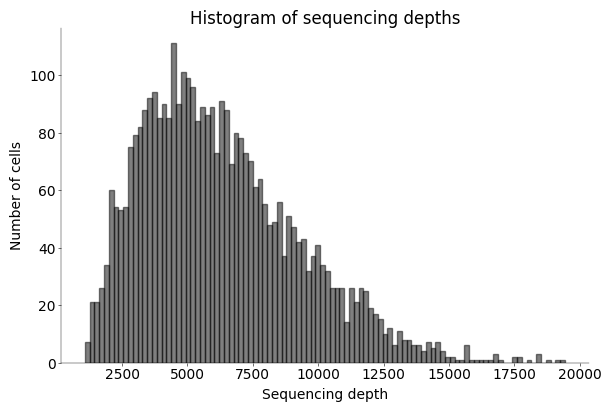

In [68]:
# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(
    sequence_depth,
    bins=100,
    color="black",
    alpha=0.5,
    edgecolor="black",
)
ax.set_xlabel("Sequencing depth")
ax.set_ylabel("Number of cells")
ax.set_title("Histogram of sequencing depths")

### 1.5. Fano factors after normalization

Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth. Then make the same expression vs Fano factor plot as above. After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(2.5 pts)_

In [ ]:
# -------------------------------------------------
# compute normalized counts and fano factor (1 pt)
# -------------------------------------------------

# counts is a 2D array with shape (cells, genes)

# normalize counts by sequencing depth
normalized_counts = (counts.T / sequence_depth).T * np.median(sequence_depth)
# compute normalized fano factor
normalized_fano = np.var(normalized_counts, axis=0) / np.mean(normalized_counts, axis=0)
# add the normalized fano factor to the gene expression DataFrame
gene_expression["normalized_fano"] = normalized_fano

ValueError: operands could not be broadcast together with shapes (3663,17965) (3663,) 

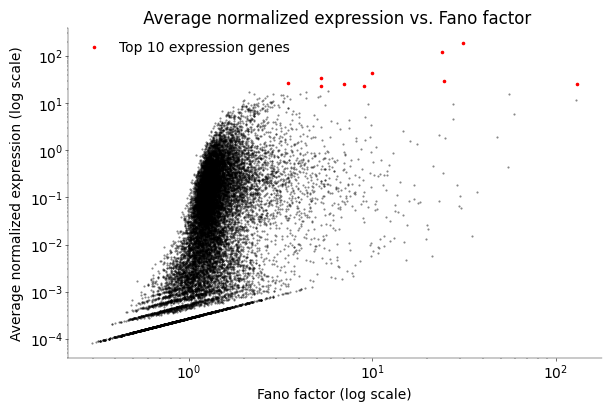

In [ ]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (1 pt)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

# find the top 10 genes with highest average normalized expression
top10_genes = np.argsort(normalized_counts.mean(axis=0))[-10:]

fig, ax = plt.subplots(figsize=(6, 4))
# add plot
# plot all genes
ax.scatter(
    normalized_fano,
    normalized_counts.mean(axis=0),
    s=1,
    color="black",
    alpha=0.5,
)
# highlight the top 10 gene expression genes
ax.scatter(
    normalized_fano[top10_genes],
    normalized_counts[:, top10_genes].mean(axis=0),
    s=10,
    color="red",
    label="Top 10 expression genes",
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Fano factor (log scale)")
ax.set_ylabel("Average normalized expression (log scale)")
ax.set_title(" Average normalized expression vs. Fano factor")
ax.legend()

In [ ]:
# --------------------------------------------------------------------
# Find top-10 genes with the highest normalized Fano factor (0.5 pts)
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
# --------------------------------------------------------------------

# print the top 10 genes with highest normalized Fano factor from gene_expression
top10_fano_genes = gene_expression.nlargest(10, "normalized_fano")
top10_fano_genes

,gene,avg_expression,fraction_zeros,poisson_fraction_zeros,fraction_zeros_diff,variance,normalized_fano
17147,Pcdh12,0.001638,0.998362,0.998363,-0.000001,4364.055224,131.141528
17104,Pcdhb16,0.032214,0.974338,0.968299,0.006039,1955.561557,128.399025
2823,Fam3a,0.087087,0.918919,0.916597,0.002322,144.011548,59.114915
16904,9430020K01Rik,0.012831,0.987442,0.987251,0.000191,2218.244579,55.651055
310,D630023F18Rik,0.030030,0.971335,0.970416,0.000919,1.600770,55.220317
11686,4933433G15Rik,0.002184,0.997816,0.997818,-0.000002,182.366184,47.650075
12703,Pelp1,0.071799,0.930931,0.930718,0.000213,0.686591,37.246247
9515,Mcoln1,0.162435,0.852853,0.850071,0.002782,0.042545,35.055421
10036,Gm26664,0.010647,0.989353,0.989409,-0.000056,10713.599421,31.422610
6366,Pon2,0.011193,0.990991,0.988869,0.002122,1.088111,30.589529


# Task 2: Low dimensional visualization

In this task we will construct a two dimensional visualization of the data. First we will normalize the data with some variance stabilizing transformation and study the effect that different approaches have on the data. Second, we will reduce the dimensionality of the data to a more feasible number of dimensions (e.g. $d=50$) using PCA. And last, we will project the PCA-reduced data to two dimensions using t-SNE.

### 2.1. PCA with and without transformations

Here we look at the influence of variance-stabilizing transformations on PCA. We will focus on the following transformations: 
- Square root (`sqrt(X)`): it is a variance-stabilizing transformation for the Poisson data. 
- Log-transform (`log2(X+1)`): it is also often used in the transcriptomic community. 

We will only work with the most important genes. For that, transform the counts into normalized counts (as above) and select all genes with normalized Fano factor above 3 and remove the rest. We will look at the effect that both transformations have in the PCA-projected data by visualizing the first two components. Interpret qualitatively what you see in the plot and compare the different embeddings making use of the ground truth clusters.

_(3.5 pts)_

In [ ]:
# --------------------------------
# Select important genes (0.5 pts)
# --------------------------------

# get indices with fano factor > 3
selected_idx = np.where(gene_expression["normalized_fano"] > 3)[0]
# print the number of selected genes
print(f"Number of selected genes: {len(selected_idx)}")

Number of selected genes: 707


In [ ]:
# --------------------------------------
# transform data and apply PCA (1 pt)
# --------------------------------------

from sklearn.decomposition import PCA

# perform PCA
n_components = 50
pca = PCA(n_components=n_components, random_state=42)
# select counts that are aboe
selected_counts = normalized_counts[:, selected_idx]

# perform sqrt normalization
selected_counts_sqrt = np.sqrt(selected_counts)
# perform log2(x + 1) transformation
selected_counts_log = np.log2(selected_counts + 1)
# apply PCA to the selected counts
pca_result_sqrt = pca.fit_transform(selected_counts_sqrt)
pca_result_log = pca.fit_transform(selected_counts_log)
pca_result = pca.fit_transform(selected_counts)

Text(0.5, 1.0, 'PCA on raw counts')

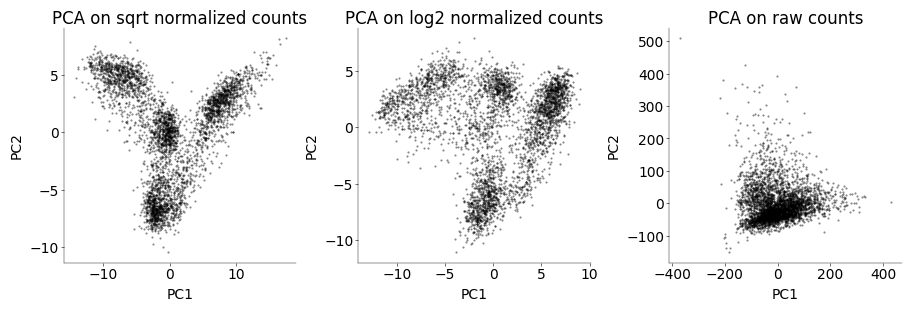

In [ ]:
# ------------------------------------------------
# plot first 2 PCs for each transformation (1 pt)
# ------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
axs[0].scatter(
    pca_result_sqrt[:, 0],
    pca_result_sqrt[:, 1],
    s=1,
    color="black",
    alpha=0.5,
)
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")
axs[0].set_title("PCA on sqrt normalized counts")
axs[1].scatter(
    pca_result_log[:, 0],
    pca_result_log[:, 1],
    s=1,
    color="black",
    alpha=0.5,
)
axs[1].set_xlabel("PC1")
axs[1].set_ylabel("PC2")
axs[1].set_title("PCA on log2 normalized counts")
axs[2].scatter(
    pca_result[:, 0],
    pca_result[:, 1],
    s=1,
    color="black",
    alpha=0.5,
)
axs[2].set_xlabel("PC1")
axs[2].set_ylabel("PC2")
axs[2].set_title("PCA on raw counts")

_Explanation (1 pt)_
...

### 2.2. tSNE with and without transformations

Now, we will reduce the dimensionality of the PCA-reduced data further to two dimensions using t-SNE. We will use only $n=50$ components of the PCA-projected data. Plot the t-SNE embedding for the three versions of the data and interpret the plots. Do the different transformations have any effect on t-SNE?

_(1.5 pts)_

In [ ]:
# -----------------------
# Perform tSNE (0.5 pts)
# -----------------------

# perform tSNE on both PCA results
tsne_sqrt = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1).fit(
    pca_result_sqrt
)
tsne_log = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1).fit(
    pca_result_log
)
tsne_result = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1).fit(
    pca_result
)

Text(0.5, 1.0, 't-SNE on raw counts')

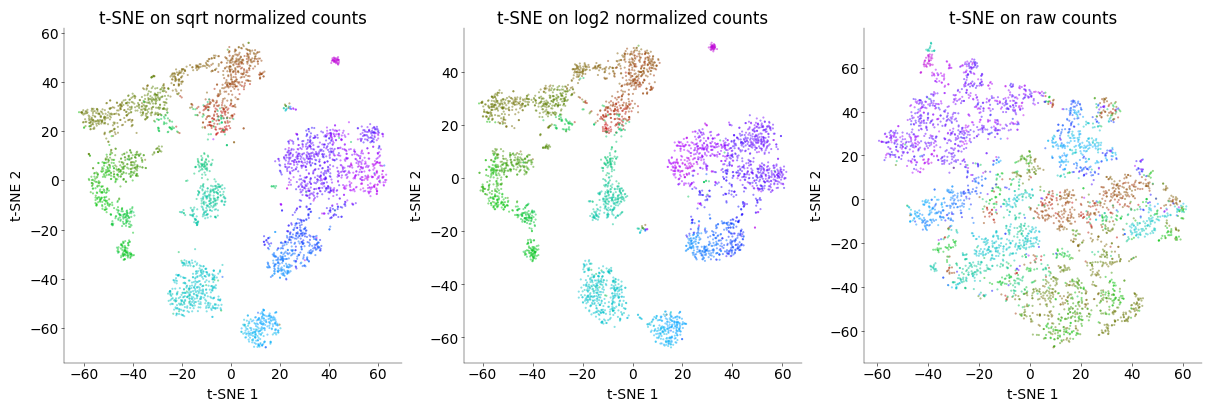

In [ ]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (1 pt)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Use cluster colors for ground truth clusters
scatter_kwargs = dict(s=1, alpha=0.5, c=clusterColors[clusters])

axs[0].scatter(tsne_sqrt[:, 0], tsne_sqrt[:, 1], **scatter_kwargs)
axs[0].set_xlabel("t-SNE 1")
axs[0].set_ylabel("t-SNE 2")
axs[0].set_title("t-SNE on sqrt normalized counts")

axs[1].scatter(tsne_log[:, 0], tsne_log[:, 1], **scatter_kwargs)
axs[1].set_xlabel("t-SNE 1")
axs[1].set_ylabel("t-SNE 2")
axs[1].set_title("t-SNE on log2 normalized counts")

axs[2].scatter(tsne_result[:, 0], tsne_result[:, 1], **scatter_kwargs)
axs[2].set_xlabel("t-SNE 1")
axs[2].set_ylabel("t-SNE 2")
axs[2].set_title("t-SNE on raw counts")

### 2.3. Leiden clustering

Now we will play around with some clustering and see whether the clustering methods can produce similar results to the original clusters from the publication. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets. 

Choose one representation of the data (best transformation based in your results from the previous task) to use further in this task and justify your choice. Think about which level of dimensionality would be sensible to use to perform clustering. Visualize in the two-dimensional embedding the resulting clusters and compare to the original clusters. 

_(1.5 pts)_

In [ ]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [ ]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

In [ ]:
# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15
A = kneighbors_graph(
    pca_result_log, n_neighbors=15, mode="connectivity", include_self=False
).astype("bool")

# Transform it into an igraph object
sources, targets = A.nonzero()
G = ig.Graph()
G.add_vertices(A.shape[0])
G.add_edges(zip(sources, targets))

# Run Leiden clustering
# Pass the partition type class, not an instance
partition = la.find_partition(
    G, la.RBConfigurationVertexPartition, resolution_parameter=1.0
)

Number of clusters: 16


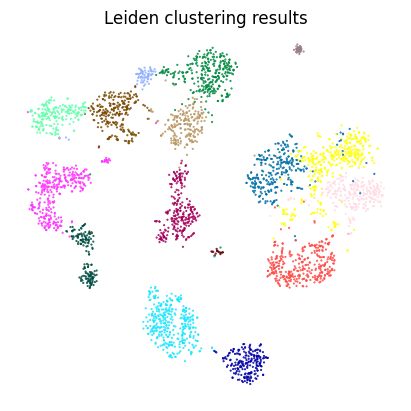

In [ ]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, ax = plt.subplots(figsize=(4, 4))

# plot Leiden clustering results with contrast colors
ax.scatter(
    tsne_log[:, 0],
    tsne_log[:, 1],
    s=1,
    c=clusterCols[partition.membership],
    alpha=1,
)

ax.set_title("Leiden clustering results")
# Add cluster colors as legend
for i, color in enumerate(clusterCols):
    ax.scatter([], [], color=color, label=f"Cluster {i + 1}")
# hide axes
ax.axis("off")

# print the number of clusters
print(f"Number of clusters: {len(np.unique(partition.membership))}")

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter. How many clusters did we get with the default value? Change the resolution parameter to yield 2x more and 2x fewer clusters
Plot all three results as t-SNE overlays (same as above).

_(1.5 pts)_

In [ ]:
# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

# resolution parameters
resolution = [0.1, 0.5, 3]
partitions = []
for res in resolution:
    partition = la.find_partition(
        G, la.RBConfigurationVertexPartition, resolution_parameter=res
    )
    partitions.append(partition)

/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_915/1675028249.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


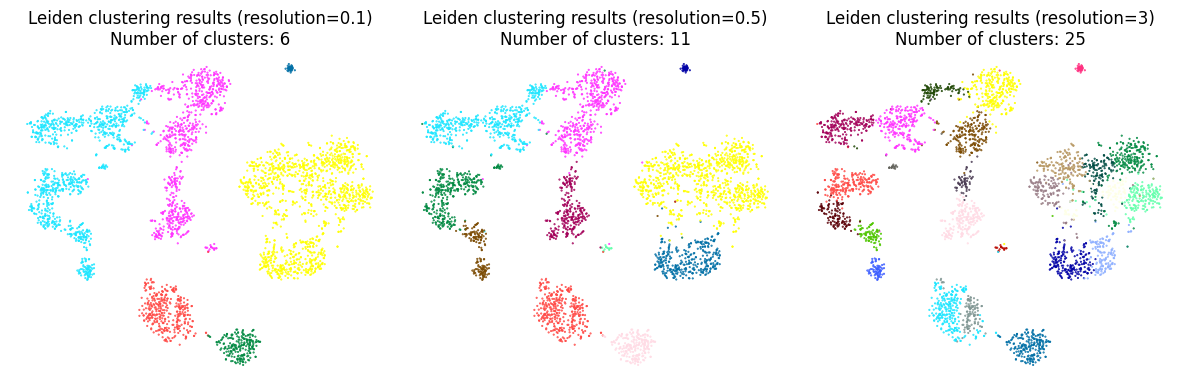

In [ ]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# add plot
for i, partition in enumerate(partitions):
    axs[i].scatter(
        tsne_log[:, 0],
        tsne_log[:, 1],
        s=1,
        c=clusterCols[partition.membership],
        alpha=1,
    )
    # Add cluster colors as legend
    for j, color in enumerate(clusterCols):
        axs[i].scatter([], [], color=color, label=f"Cluster {j + 1}")
    # show number of clusters in plot
    axs[i].set_title(
        f"Leiden clustering results (resolution={resolution[i]})\n"
        f"Number of clusters: {len(np.unique(partition.membership))}"
    )
    # hide axes
    axs[i].axis("off")
plt.tight_layout()